## Extracting LSTM features and Feature Maps from the main data
To better understand the code, check out `./prep_files/preprocessing_synced_for_MTL.ipynb`. That notebook explains the thought process behind this code on a sample dataset whilst this goes straight to the point.

In [1]:
import pandas as pd
import numpy as np
import src.preprocess
from src.preprocess import LSTM_featureExtractor, Prep_data_for_CNN

In [2]:
data = pd.read_csv('./data/concat_users.csv')

In [3]:
data.groupby(['User', 'Position'])['Segment'].count()

User   Position
User1  Bag         304434
       Hand        304438
       Hips        304434
       Torso       304430
User2  Bag         372171
       Hand        372170
       Hips        372172
       Torso       372177
User3  Bag         347627
       Hand        347627
       Hips        347627
       Torso       347626
Name: Segment, dtype: int64

In [7]:
sub_segmented_data = src.preprocess.create_sub_segments(data, window_size=112, overlap=0.5)
sub_segmented_data.to_csv('./data/sub_segmented_data.csv', index=False, header=True)

In [10]:
del data, sub_segmented_data

-----

In [12]:
subbed_data = pd.read_csv('./data/sub_segmented_data.csv')

In [13]:
subbed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8092672 entries, 0 to 8092671
Data columns (total 18 columns):
 #   Column          Dtype  
---  ------          -----  
 0   time_ms         float64
 1   acceleration_x  float64
 2   acceleration_y  float64
 3   acceleration_z  float64
 4   gyroscope_x     float64
 5   gyroscope_y     float64
 6   gyroscope_z     float64
 7   orientation_w   float64
 8   orientation_x   float64
 9   orientation_y   float64
 10  orientation_z   float64
 11  Date            int64  
 12  Position        object 
 13  Coarse_label    float64
 14  Fine_label      float64
 15  Segment         int64  
 16  User            object 
 17  Sub_Segment     int64  
dtypes: float64(13), int64(3), object(2)
memory usage: 1.1+ GB


### Feature Extraction for LSTM

In [14]:
lstm_featExtract = LSTM_featureExtractor(subbed_data, num_features=6, window=112)

In [15]:
lstm_features, lstm_labels = lstm_featExtract.feature_extractor(start=0)

In [18]:
np.save('./data/lstm_features_labels/full_lstm_features.npy', lstm_features)
np.save('./data/lstm_features_labels/full_lstm_labels.npy', lstm_labels)

In [19]:
print(lstm_features.shape)  # Should be (num_samples, window, num_features)
print(lstm_labels.shape)    # Should be (num_samples,)

(72256, 112, 6)
(72256,)


In [20]:
del lstm_features, lstm_labels

### Feature Extraction for CNN-RNN

In [21]:
subbed_data.query("Coarse_label == 5.0 & Position=='Hand'").groupby(['User','Segment'])[['Sub_Segment']].count()

Sub_Segment
User  Segment             
User1 5              35728
      7              33040
      9              18928
      12             11088
User2 64             67088
      66             14672
      70             26880
      73             27440
      75             17584
User3 22             50288

This data has 3 drivers whilst my sample had 2.

In [22]:
subbed_data.query("Coarse_label == 5.0").groupby('User')[['Segment','Sub_Segment']].nunique()

,Segment,Sub_Segment
User,,
User1,4,882
User2,5,1372
User3,1,449


In [29]:
windowed_df = Prep_data_for_CNN().get_window_df_from_dir('./data/sub_segmented_data.csv',
                                                         prep_for_FMAPextract=False)

time it took: `304m 0.5s`

In [30]:
windowed_df.to_csv('./data/windowed_df.csv', index=False, header=True)

I should have set `prep_for_FMAPextract=True` because I need the full windowed_df to be able to split it into train and test without leaking data into the SimpleCNN. I'll do it manually.

In [31]:
len(windowed_df)

36304

In [33]:
windowed_df['user'] = windowed_df['user_act'].values
del windowed_df['user_act']

In [36]:
windowed_df = Prep_data_for_CNN().prep_for_FMAPextract(subbed_data, windowed_df)

# change other labels to `Not_driving`  (a dummy label)
windowed_df['user_act'] = windowed_df['user'].values
idx_users = windowed_df.query('coarse_label == 5.0').index
df_with_drivers = windowed_df.index.isin(idx_users)
windowed_df.loc[~df_with_drivers, 'user'] = 'Not_driving'

In [37]:
windowed_df.to_csv('./data/full_windowed_df.csv', index=False, header=True)

In [38]:
len(windowed_df)

72256

----

This `full_windowed_df` is made up of duplicates and interpolated data. As a result, I'll need to take 80:20 of the duplicates (original and corr dupe) as well as 80:20 of interpolated data.

In [4]:
def converter(instr):
    return np.fromstring(instr[1:-1],sep=' ')

windowed_df = pd.read_csv(
    './data/full_windowed_df.csv',
    converters={
        'long_acc_window': converter,
        'tranv_acc_window': converter,
        'ang_vel_window': converter
    }
)

In [5]:
windowed_df.columns

Index(['user', 'coarse_label', 'segment', 'position', 'window_index',
       'long_acc_window', 'tranv_acc_window', 'ang_vel_window', 'Interp_Flag',
       'Dupl_Flag', 'Train_Flag', 'user_act'],
      dtype='object')

In [6]:
idx_non_dupe = windowed_df.query("Dupl_Flag==0 & Interp_Flag==0").index
idx_interp = windowed_df.query("Dupl_Flag==0 & Interp_Flag==1").index

For each non_dupe, it's corresponding duplicate is the next idx

Get training and test index

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
tr_idx_nondupe, test_idx_nondupe = train_test_split(idx_non_dupe,
                                                    test_size=0.2,
                                                    stratify=windowed_df.loc[idx_non_dupe, 'user_act'].values,
                                                    random_state=42)

tr_idx_interp, test_idx_interp = train_test_split(idx_interp,
                                                  test_size=0.2,
                                                  stratify=windowed_df.loc[idx_interp, 'user_act'].values,
                                                  random_state=42)

In [9]:
# get the idx for the duplicates
tr_idx_dupe = tr_idx_nondupe+1
test_idx_dupe = test_idx_nondupe+1

In [10]:
train_idx = np.concatenate([tr_idx_nondupe, tr_idx_dupe, tr_idx_interp], axis=None)
test_idx = np.concatenate([test_idx_nondupe, test_idx_dupe, test_idx_interp], axis=None)

In [11]:
## subsetting only the training data
windowed_df = windowed_df.loc[train_idx, :]

Begin hyperparam tuning for SimpleCNN

In [12]:
X, y, uniq = Prep_data_for_CNN().prep_input_for_CNN(windowed_df)

In [13]:
uniq, np.unique(y)

(array(['Not_driving', 'User1', 'User2', 'User3'], dtype='<U11'),
 array([0, 1, 2, 3], dtype=int64))

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [15]:
X.shape

(57803, 3, 224)

In [16]:
# Perform a train-test split
np.random.seed(42)
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_tr, y_tr, test_size=0.2, stratify=y_tr)

class_weights = torch.tensor(compute_class_weight('balanced', classes=np.unique(y_train), y=y_train), dtype=torch.float32)
class_weights = class_weights.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# normalizing X
mean = X_train.mean(axis=(0, 2), keepdims=True)
std = X_train.std(axis=(0, 2), keepdims=True)

X_train = (X_train - mean) / std
X_valid = (X_valid - mean) / std
X_test = (X_test - mean) / std

In [17]:
from src.dataset import SignalsDataset

In [18]:
# Create datasets for each feature
feature_indices = {'long_acc': 0, 'tranv_acc': 1, 'ang_vel': 2}

train_datasets = {feature: SignalsDataset(X_train, y_train, idx) for feature, idx in feature_indices.items()}
valid_datasets = {feature: SignalsDataset(X_valid, y_valid, idx) for feature, idx in feature_indices.items()}
test_datasets = {feature: SignalsDataset(X_test, y_test, idx) for feature, idx in feature_indices.items()}

In [44]:
from src.engine import simpleCNN_engine
from src.model_simpleCNN import SimpleCNN
from src.dataset import SignalsDataset
from src.preprocess import Prep_data_for_CNN
from src.hyperparam import RayTuning
from ray import tune, train

from IPython.display import display, HTML

# Load custom CSS file
css = HTML('<link rel="stylesheet" type="text/css" href="./custom.css">')  # Ensure the path is correct
display(css)

In [46]:
SimpleCNN()

SimpleCNN(
  (conv1): Conv1d(1, 224, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv2d(224, 224, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=50176, out_features=4, bias=True)
)

#### Hyperparam Tuning

Hyperparam Tuning - Long Model

In [47]:
# Enhanced Hyperparameter search space
config = {
    "optimizer": tune.choice(["adam"]),
    "lr": tune.loguniform(1e-4, 1e-1),
    "scheduler": tune.choice(["exp"]),
    "gamma": tune.uniform(0.1, 0.9),
    "epochs": tune.choice([30]),
    "batch_size": tune.choice([32])
}

criterion = nn.CrossEntropyLoss(weight=class_weights)
save_dir = 'SimpleCNN_long'
model = SimpleCNN
modelType = 'SimpleCNN'
engine = simpleCNN_engine

In [48]:
mytuner = RayTuning(config, save_dir, criterion, model, modelType, engine)

In [49]:
mytuner.main(train_datasets['long_acc'], valid_datasets['long_acc'], 
             test_datasets['long_acc'], num_samples=25)

(train_model pid=21856) Checkpoint successfully created at: Checkpoint(filesystem=local, path=c:/Users/LEGION/Documents/Msc Data Science - Uni of Exeter/ECMM451 - Data Science Research Project (2023)/workspace/ray_results/SimpleCNN_long/trial_5d70b_00000/checkpoint_000000)
(train_model pid=21856) Checkpoint successfully created at: Checkpoint(filesystem=local, path=c:/Users/LEGION/Documents/Msc Data Science - Uni of Exeter/ECMM451 - Data Science Research Project (2023)/workspace/ray_results/SimpleCNN_long/trial_5d70b_00000/checkpoint_000001)
(train_model pid=21856) Checkpoint successfully created at: Checkpoint(filesystem=local, path=c:/Users/LEGION/Documents/Msc Data Science - Uni of Exeter/ECMM451 - Data Science Research Project (2023)/workspace/ray_results/SimpleCNN_long/trial_5d70b_00000/checkpoint_000002)
(train_model pid=21856) Checkpoint successfully created at: Checkpoint(filesystem=local, path=c:/Users/LEGION/Documents/Msc Data Science - Uni of Exeter/ECMM451 - Data Science Re

Best trial config: {'optimizer': 'adam', 'lr': 0.00011113828101205411, 'scheduler': 'exp', 'gamma': 0.8492356384312725, 'epochs': 30, 'batch_size': 32}
Best trial final validation loss: 1.1141672693449876
Best trial final validation accuracy: 61.4445%
Test Accuracy: 0.6260704091341579
Best trial test set accuracy: 0.6261%


Hyperparam Tuning - Tranv Model

In [50]:
# Enhanced Hyperparameter search space
config = {
    "optimizer": tune.choice(["adam"]),
    "lr": tune.loguniform(1e-4, 1e-1),
    "scheduler": tune.choice(["exp"]),
    "gamma": tune.uniform(0.1, 0.9),
    "epochs": tune.choice([30]),
    "batch_size": tune.choice([32])
}

criterion = nn.CrossEntropyLoss(weight=class_weights)
save_dir = 'SimpleCNN_tranv'
model = SimpleCNN
modelType = 'SimpleCNN'
engine = simpleCNN_engine

In [51]:
mytuner = RayTuning(config, save_dir, criterion, model, modelType, engine)

In [52]:
mytuner.main(train_datasets['tranv_acc'], valid_datasets['tranv_acc'], 
             test_datasets['tranv_acc'], num_samples=25)

(train_model pid=8396) Checkpoint successfully created at: Checkpoint(filesystem=local, path=c:/Users/LEGION/Documents/Msc Data Science - Uni of Exeter/ECMM451 - Data Science Research Project (2023)/workspace/ray_results/SimpleCNN_tranv/trial_99950_00000/checkpoint_000000)
(train_model pid=8396) Checkpoint successfully created at: Checkpoint(filesystem=local, path=c:/Users/LEGION/Documents/Msc Data Science - Uni of Exeter/ECMM451 - Data Science Research Project (2023)/workspace/ray_results/SimpleCNN_tranv/trial_99950_00000/checkpoint_000001)
(train_model pid=8396) Checkpoint successfully created at: Checkpoint(filesystem=local, path=c:/Users/LEGION/Documents/Msc Data Science - Uni of Exeter/ECMM451 - Data Science Research Project (2023)/workspace/ray_results/SimpleCNN_tranv/trial_99950_00000/checkpoint_000002)
(train_model pid=8396) Checkpoint successfully created at: Checkpoint(filesystem=local, path=c:/Users/LEGION/Documents/Msc Data Science - Uni of Exeter/ECMM451 - Data Science Res

2024-07-23 05:18:16,160	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'c:/Users/LEGION/Documents/Msc Data Science - Uni of Exeter/ECMM451 - Data Science Research Project (2023)/workspace/ray_results/SimpleCNN_tranv' in 0.0400s.
2024-07-23 05:18:16,180	INFO tune.py:1041 -- Total run time: 5576.65 seconds (5576.56 seconds for the tuning loop).


Best trial config: {'optimizer': 'adam', 'lr': 0.00015558427999575448, 'scheduler': 'exp', 'gamma': 0.6560277884599833, 'epochs': 30, 'batch_size': 32}
Best trial final validation loss: 1.1554321087639905
Best trial final validation accuracy: 68.9804%
Test Accuracy: 0.6977770089092639
Best trial test set accuracy: 0.6978%


Hyperparam Tuning - Ang. Vel Model

In [53]:
# Enhanced Hyperparameter search space
config = {
    "optimizer": tune.choice(["adam"]),
    "lr": tune.loguniform(1e-4, 1e-1),
    "scheduler": tune.choice(["exp"]),
    "gamma": tune.uniform(0.1, 0.9),
    "epochs": tune.choice([30]),
    "batch_size": tune.choice([32])
}

criterion = nn.CrossEntropyLoss(weight=class_weights)
save_dir = 'SimpleCNN_ang_vel'
model = SimpleCNN
modelType = 'SimpleCNN'
engine = simpleCNN_engine

In [54]:
mytuner = RayTuning(config, save_dir, criterion, model, modelType, engine)

In [55]:
mytuner.main(train_datasets['ang_vel'], valid_datasets['ang_vel'], 
             test_datasets['ang_vel'], num_samples=25)

2024-07-23 06:23:21,580	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'c:/Users/LEGION/Documents/Msc Data Science - Uni of Exeter/ECMM451 - Data Science Research Project (2023)/workspace/ray_results/SimpleCNN_ang_vel' in 0.0300s.
2024-07-23 06:23:21,607	INFO tune.py:1041 -- Total run time: 3889.56 seconds (3889.50 seconds for the tuning loop).


Best trial config: {'optimizer': 'adam', 'lr': 0.00013662142756319453, 'scheduler': 'exp', 'gamma': 0.4740572036017916, 'epochs': 30, 'batch_size': 32}
Best trial final validation loss: 1.138420147525853
Best trial final validation accuracy: 66.7207%
Test Accuracy: 0.6771905544503071
Best trial test set accuracy: 0.6772%


To view tensorboard, run below in terminal;

`tensorboard --logdir="c:/Users/LEGION/Documents/Msc Data Science - Uni of Exeter/ECMM451 - Data Science Research Project (2023)/workspace/ray_results/SimpleCNN_long"`

-----

#### Model Training
Time to train the model with the given optimal hyperparameters

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from src.model_simpleCNN import SimpleCNN
from src.engine import simpleCNN_engine

In [20]:
np.random.seed(42)

batch_size = 32
train_dl_long = DataLoader(train_datasets['long_acc'], batch_size, shuffle=True, num_workers=4)
train_dl_tranv = DataLoader(train_datasets['tranv_acc'], batch_size, shuffle=True, num_workers=4)
train_dl_angvel = DataLoader(train_datasets['ang_vel'], batch_size, shuffle=True, num_workers=4)

valid_dl_long = DataLoader(valid_datasets['long_acc'], batch_size, shuffle=True, num_workers=4)
valid_dl_tranv = DataLoader(valid_datasets['tranv_acc'], batch_size, shuffle=True, num_workers=4)
valid_dl_angvel = DataLoader(valid_datasets['ang_vel'], batch_size, shuffle=True, num_workers=4)

test_dl_long = DataLoader(test_datasets['long_acc'], batch_size, shuffle=False, num_workers=2)
test_dl_tranv = DataLoader(test_datasets['tranv_acc'], batch_size, shuffle=False, num_workers=2)
test_dl_angvel = DataLoader(test_datasets['ang_vel'], batch_size, shuffle=False, num_workers=2)

Longitudinal acceleration

In [29]:
criterion = nn.CrossEntropyLoss(weight=class_weights)
model_long = SimpleCNN()
optimizer_long = optim.Adam(model_long.parameters(), lr=0.00011113828101205411)
scheduler_long = optim.lr_scheduler.ExponentialLR(optimizer_long, gamma=0.8492356384312725)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_long = model_long.to(device)

In [30]:
engine_long = simpleCNN_engine(model_long, optimizer_long, scheduler_long, criterion, device)

In [31]:
long_hist = engine_long.train_validation(train_dl_long, valid_dl_long, epochs=40, save_path='./model_checkpoint/run1_simpleCNN_long_chkpt.pth')

np.save('./model_checkpoint/run1_long_history.npy', np.array(long_hist))

   Epoch [1/40], Train Loss: 1.3286, Train Accuracy: 39.23%, Val Loss: 1.3104, Val Accuracy: 31.56%
   Epoch [2/40], Train Loss: 1.2925, Train Accuracy: 35.90%, Val Loss: 1.2938, Val Accuracy: 46.71%
   Epoch [3/40], Train Loss: 1.2662, Train Accuracy: 38.84%, Val Loss: 1.2623, Val Accuracy: 44.75%
   Epoch [4/40], Train Loss: 1.2091, Train Accuracy: 46.81%, Val Loss: 1.2171, Val Accuracy: 56.19%
   Epoch [5/40], Train Loss: 1.1340, Train Accuracy: 61.55%, Val Loss: 1.1841, Val Accuracy: 67.09%
   Epoch [6/40], Train Loss: 1.0782, Train Accuracy: 66.04%, Val Loss: 1.1762, Val Accuracy: 75.54%
   Epoch [7/40], Train Loss: 1.0390, Train Accuracy: 67.64%, Val Loss: 1.1391, Val Accuracy: 68.08%
   Epoch [8/40], Train Loss: 1.0090, Train Accuracy: 69.23%, Val Loss: 1.1286, Val Accuracy: 63.36%
   Epoch [9/40], Train Loss: 0.9887, Train Accuracy: 69.74%, Val Loss: 1.1206, Val Accuracy: 71.31%
   Epoch [10/40], Train Loss: 0.9648, Train Accuracy: 69.96%, Val Loss: 1.1034, Val Accuracy: 68.32%

Tranversal Acceleration

In [32]:
criterion = nn.CrossEntropyLoss(weight=class_weights)
model_tranv = SimpleCNN()
optimizer_tranv = optim.Adam(model_tranv.parameters(), lr=0.00015558427999575448)
scheduler_tranv = optim.lr_scheduler.ExponentialLR(optimizer_tranv, gamma=0.6560277884599833)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_tranv = model_tranv.to(device)

In [33]:
engine_tranv = simpleCNN_engine(model_tranv, optimizer_tranv, scheduler_tranv, criterion, device)

In [34]:
tranv_hist = engine_tranv.train_validation(train_dl_tranv, valid_dl_tranv, epochs=40, save_path='./model_checkpoint/run1_simpleCNN_tranv_chkpt.pth')

np.save('./model_checkpoint/run1_tranv_history.npy', np.array(tranv_hist))

   Epoch [1/40], Train Loss: 1.3274, Train Accuracy: 40.59%, Val Loss: 1.3034, Val Accuracy: 32.94%
   Epoch [2/40], Train Loss: 1.2930, Train Accuracy: 37.02%, Val Loss: 1.2983, Val Accuracy: 31.38%
   Epoch [3/40], Train Loss: 1.2636, Train Accuracy: 38.70%, Val Loss: 1.2847, Val Accuracy: 40.63%
   Epoch [4/40], Train Loss: 1.2065, Train Accuracy: 48.59%, Val Loss: 1.2414, Val Accuracy: 61.71%
   Epoch [5/40], Train Loss: 1.1552, Train Accuracy: 58.14%, Val Loss: 1.2038, Val Accuracy: 64.50%
   Epoch [6/40], Train Loss: 1.1254, Train Accuracy: 63.33%, Val Loss: 1.2062, Val Accuracy: 54.76%
   Epoch [7/40], Train Loss: 1.1019, Train Accuracy: 65.56%, Val Loss: 1.1791, Val Accuracy: 65.26%
   Epoch [8/40], Train Loss: 1.0918, Train Accuracy: 66.68%, Val Loss: 1.1738, Val Accuracy: 62.98%
   Epoch [9/40], Train Loss: 1.0863, Train Accuracy: 66.32%, Val Loss: 1.1740, Val Accuracy: 67.28%
   Epoch [10/40], Train Loss: 1.0778, Train Accuracy: 67.20%, Val Loss: 1.1746, Val Accuracy: 66.12%

Angular Velocity

In [35]:
criterion = nn.CrossEntropyLoss(weight=class_weights)
model_ang = SimpleCNN()
optimizer_ang = optim.Adam(model_ang.parameters(), lr=0.00013662142756319453)
scheduler_ang = optim.lr_scheduler.ExponentialLR(optimizer_ang, gamma=0.4740572036017916)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_ang = model_ang.to(device)

In [36]:
engine_ang = simpleCNN_engine(model_ang, optimizer_ang, scheduler_ang, criterion, device)

In [37]:
ang_hist = engine_ang.train_validation(train_dl_angvel, valid_dl_angvel, epochs=40, save_path='./model_checkpoint/run1_simpleCNN_angvel_chkpt.pth')

np.save('./model_checkpoint/run1_angvel_history.npy', np.array(ang_hist))

   Epoch [1/40], Train Loss: 1.2237, Train Accuracy: 64.55%, Val Loss: 1.1658, Val Accuracy: 68.68%
   Epoch [2/40], Train Loss: 1.1400, Train Accuracy: 66.53%, Val Loss: 1.1491, Val Accuracy: 63.81%
   Epoch [3/40], Train Loss: 1.0930, Train Accuracy: 67.72%, Val Loss: 1.1389, Val Accuracy: 66.05%
   Epoch [4/40], Train Loss: 1.0721, Train Accuracy: 68.02%, Val Loss: 1.1337, Val Accuracy: 68.36%
   Epoch [5/40], Train Loss: 1.0613, Train Accuracy: 68.63%, Val Loss: 1.1328, Val Accuracy: 68.70%
   Epoch [6/40], Train Loss: 1.0600, Train Accuracy: 68.60%, Val Loss: 1.1305, Val Accuracy: 66.74%
   Epoch [7/40], Train Loss: 1.0546, Train Accuracy: 68.44%, Val Loss: 1.1358, Val Accuracy: 67.76%
   Epoch [8/40], Train Loss: 1.0558, Train Accuracy: 68.75%, Val Loss: 1.1314, Val Accuracy: 67.10%
   Epoch [9/40], Train Loss: 1.0535, Train Accuracy: 68.51%, Val Loss: 1.1312, Val Accuracy: 67.11%
   Epoch [10/40], Train Loss: 1.0537, Train Accuracy: 68.65%, Val Loss: 1.1368, Val Accuracy: 66.98%

Plotting history

In [23]:
from src.plot import plot_history

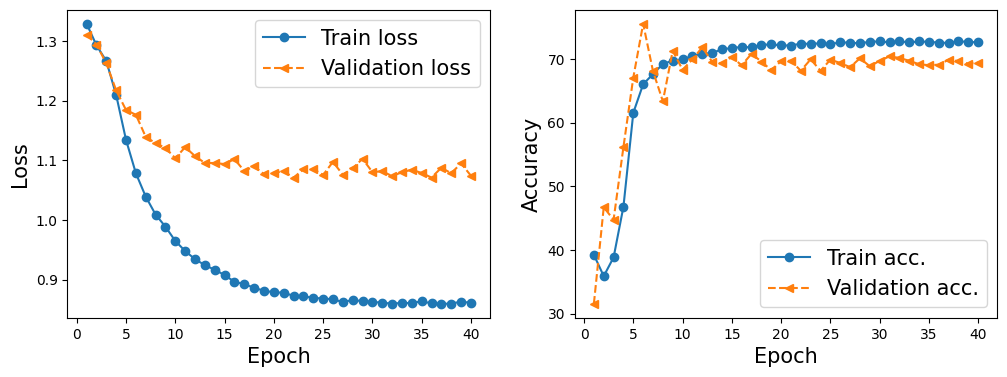

In [39]:
plot_history(long_hist)

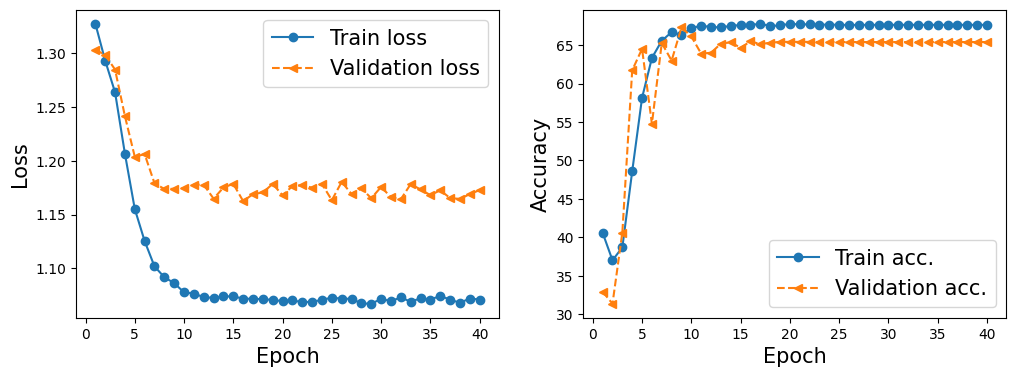

In [40]:
plot_history(tranv_hist)

I made an error when saving `ang_hist` so I lost it after restarting my kernel

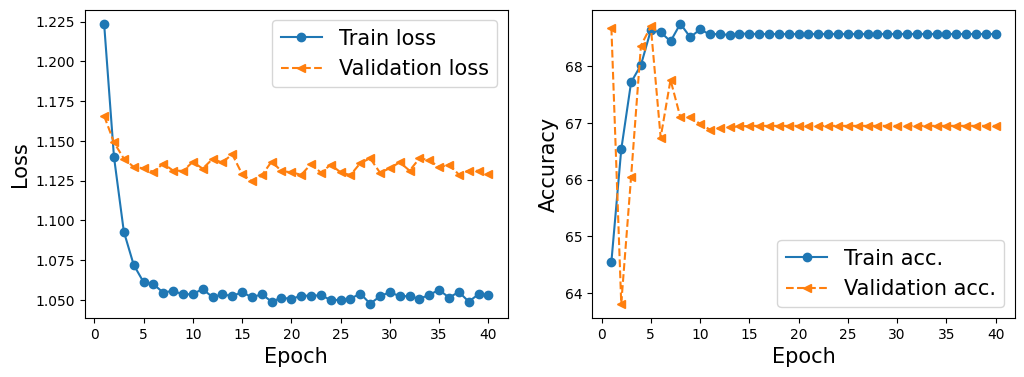

In [41]:
plot_history(ang_hist)

Testing the model on the test set drawn from the windowed_df[training]

In [42]:
## I can use any engine for this
engine_long.test_all(model_long, model_tranv, model_ang, 
                     test_dl_long, test_dl_tranv, test_dl_angvel)

Agreement accuracy among models: 0.7302136493382926


Seeing as the original training data was split to get training, validation and test set (64:16:20), this means that the models were trained on just 64% of the training data, leaving 36% for test and val. I'll now train on these.

#### Endgame Training
Longitudinal Acceleration

In [25]:
criterion = nn.CrossEntropyLoss(weight=class_weights)
model_long = SimpleCNN()
optimizer_long = optim.Adam(model_long.parameters(), lr=0.00011113828101205411)
scheduler_long = optim.lr_scheduler.ExponentialLR(optimizer_long, gamma=0.8492356384312725)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_long = model_long.to(device)

In [27]:
# Load the checkpoint
checkpoint = torch.load('./model_checkpoint/run1_simpleCNN_long_chkpt.pth')

# Load the different states
model_long.load_state_dict(checkpoint['model_state_dict'])
optimizer_long.load_state_dict(checkpoint['optimizer_state_dict'])
scheduler_long.load_state_dict(checkpoint['scheduler_state_dict'])

# Load the loss
loss = checkpoint['loss']

print(f'Loaded states from checkpoint with loss: {loss}')

Loaded model, optimizer and scheduler state from checkpoint with loss: 0.14813733100891113


In [28]:
engine_long = simpleCNN_engine(model_long, optimizer_long, scheduler_long, criterion, device)

In [29]:
long_endgame_hist = engine_long.train_endgame(valid_dl_long, test_dl_long, epochs=40,
                                              save_path='./model_checkpoint/endgame_1_simpleCNN_long_chkpt.pth')
np.save('./model_checkpoint/endgame_1_long_history.npy', np.array(long_endgame_hist))

   Epoch [1/40], Train Loss: 1.0796, Train Accuracy: 69.22%
   Epoch [2/40], Train Loss: 1.0766, Train Accuracy: 68.61%
   Epoch [3/40], Train Loss: 1.0751, Train Accuracy: 68.59%
   Epoch [4/40], Train Loss: 1.0739, Train Accuracy: 68.43%
   Epoch [5/40], Train Loss: 1.0730, Train Accuracy: 68.43%
   Epoch [6/40], Train Loss: 1.0723, Train Accuracy: 68.50%
   Epoch [7/40], Train Loss: 1.0718, Train Accuracy: 68.41%
   Epoch [8/40], Train Loss: 1.0713, Train Accuracy: 68.37%
   Epoch [9/40], Train Loss: 1.0709, Train Accuracy: 68.37%
   Epoch [10/40], Train Loss: 1.0706, Train Accuracy: 68.44%
   Epoch [11/40], Train Loss: 1.0704, Train Accuracy: 68.42%
   Epoch [12/40], Train Loss: 1.0702, Train Accuracy: 68.45%
   Epoch [13/40], Train Loss: 1.0700, Train Accuracy: 68.46%
   Epoch [14/40], Train Loss: 1.0699, Train Accuracy: 68.40%
   Epoch [15/40], Train Loss: 1.0697, Train Accuracy: 68.39%
   Epoch [16/40], Train Loss: 1.0696, Train Accuracy: 68.41%
   Epoch [17/40], Train Loss: 1.0

Tranversal Acceleration

In [30]:
criterion = nn.CrossEntropyLoss(weight=class_weights)
model_tranv = SimpleCNN()
optimizer_tranv = optim.Adam(model_tranv.parameters(), lr=0.00015558427999575448)
scheduler_tranv = optim.lr_scheduler.ExponentialLR(optimizer_tranv, gamma=0.6560277884599833)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_tranv = model_tranv.to(device)

In [31]:
# Load the checkpoint
checkpoint = torch.load('./model_checkpoint/run1_simpleCNN_tranv_chkpt.pth')

# Load the different states
model_tranv.load_state_dict(checkpoint['model_state_dict'])
optimizer_tranv.load_state_dict(checkpoint['optimizer_state_dict'])
scheduler_tranv.load_state_dict(checkpoint['scheduler_state_dict'])

# Load the loss
loss = checkpoint['loss']

print(f'Loaded states from checkpoint with loss: {loss}')

Loaded states from checkpoint with loss: 1.6689286894688848e-06


In [32]:
engine_tranv = simpleCNN_engine(model_tranv, optimizer_tranv, scheduler_tranv, criterion, device)

In [33]:
tranv_endgame_hist = engine_tranv.train_endgame(valid_dl_tranv, test_dl_tranv, epochs=40,
                                              save_path='./model_checkpoint/endgame_1_simpleCNN_tranv_chkpt.pth')
np.save('./model_checkpoint/endgame_1_tranv_history.npy', np.array(tranv_endgame_hist))

   Epoch [1/40], Train Loss: 1.1745, Train Accuracy: 66.41%
   Epoch [2/40], Train Loss: 1.1745, Train Accuracy: 66.41%
   Epoch [3/40], Train Loss: 1.1745, Train Accuracy: 66.41%
   Epoch [4/40], Train Loss: 1.1745, Train Accuracy: 66.41%
   Epoch [5/40], Train Loss: 1.1745, Train Accuracy: 66.41%
   Epoch [6/40], Train Loss: 1.1745, Train Accuracy: 66.41%
   Epoch [7/40], Train Loss: 1.1745, Train Accuracy: 66.41%
   Epoch [8/40], Train Loss: 1.1745, Train Accuracy: 66.41%
   Epoch [9/40], Train Loss: 1.1745, Train Accuracy: 66.41%
   Epoch [10/40], Train Loss: 1.1745, Train Accuracy: 66.41%
   Epoch [11/40], Train Loss: 1.1745, Train Accuracy: 66.41%
   Epoch [12/40], Train Loss: 1.1745, Train Accuracy: 66.41%
   Epoch [13/40], Train Loss: 1.1745, Train Accuracy: 66.41%
   Epoch [14/40], Train Loss: 1.1745, Train Accuracy: 66.41%
   Epoch [15/40], Train Loss: 1.1745, Train Accuracy: 66.41%
   Epoch [16/40], Train Loss: 1.1745, Train Accuracy: 66.41%
   Epoch [17/40], Train Loss: 1.1

Angular Velocity

In [34]:
criterion = nn.CrossEntropyLoss(weight=class_weights)
model_ang = SimpleCNN()
optimizer_ang = optim.Adam(model_ang.parameters(), lr=0.00013662142756319453)
scheduler_ang = optim.lr_scheduler.ExponentialLR(optimizer_ang, gamma=0.4740572036017916)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_ang = model_ang.to(device)

In [35]:
# Load the checkpoint
checkpoint = torch.load('./model_checkpoint/run1_simpleCNN_angvel_chkpt.pth')

# Load the different states
model_ang.load_state_dict(checkpoint['model_state_dict'])
optimizer_ang.load_state_dict(checkpoint['optimizer_state_dict'])
scheduler_ang.load_state_dict(checkpoint['scheduler_state_dict'])

# Load the loss
loss = checkpoint['loss']

print(f'Loaded states from checkpoint with loss: {loss}')

Loaded states from checkpoint with loss: 0.04209281504154205


In [36]:
engine_ang = simpleCNN_engine(model_ang, optimizer_ang, scheduler_ang, criterion, device)

In [37]:
ang_endgame_hist = engine_ang.train_endgame(valid_dl_angvel, test_dl_angvel, epochs=40,
                                              save_path='./model_checkpoint/endgame_1_simpleCNN_angvel_chkpt.pth')
np.save('./model_checkpoint/endgame_1_angvel_history.npy', np.array(tranv_endgame_hist))

   Epoch [1/40], Train Loss: 1.1483, Train Accuracy: 67.63%
   Epoch [2/40], Train Loss: 1.1483, Train Accuracy: 67.63%
   Epoch [3/40], Train Loss: 1.1483, Train Accuracy: 67.63%
   Epoch [4/40], Train Loss: 1.1483, Train Accuracy: 67.63%
   Epoch [5/40], Train Loss: 1.1483, Train Accuracy: 67.63%
   Epoch [6/40], Train Loss: 1.1483, Train Accuracy: 67.63%
   Epoch [7/40], Train Loss: 1.1483, Train Accuracy: 67.63%
   Epoch [8/40], Train Loss: 1.1483, Train Accuracy: 67.63%
   Epoch [9/40], Train Loss: 1.1483, Train Accuracy: 67.63%
   Epoch [10/40], Train Loss: 1.1483, Train Accuracy: 67.63%
   Epoch [11/40], Train Loss: 1.1483, Train Accuracy: 67.63%
   Epoch [12/40], Train Loss: 1.1483, Train Accuracy: 67.63%
   Epoch [13/40], Train Loss: 1.1483, Train Accuracy: 67.63%
   Epoch [14/40], Train Loss: 1.1483, Train Accuracy: 67.63%
   Epoch [15/40], Train Loss: 1.1483, Train Accuracy: 67.63%
   Epoch [16/40], Train Loss: 1.1483, Train Accuracy: 67.63%
   Epoch [17/40], Train Loss: 1.1

Plotting only Long_hist and Tranv_hist as I've lost the first ang_hist data

In [52]:
from src.plot import plot_endgame_history
import matplotlib.pyplot as plt

%matplotlib inline

In [39]:
long_hist = np.load('./model_checkpoint/run1_long_history.npy')
tranv_hist = np.load('./model_checkpoint/run1_tranv_history.npy')

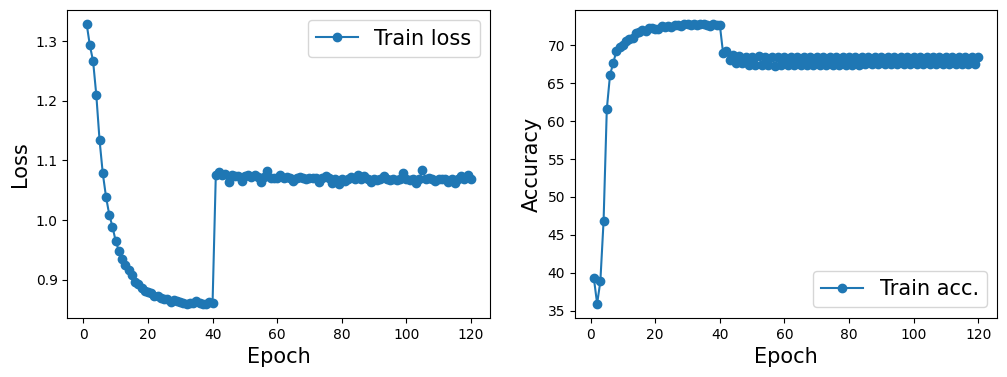

In [55]:
plot_endgame_history(long_endgame_hist, long_hist)

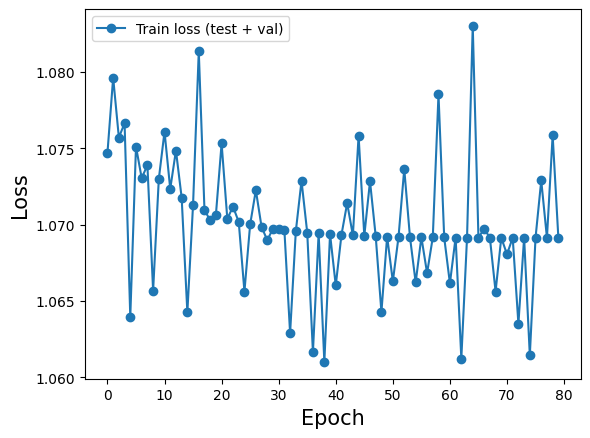

In [60]:
plt.plot(np.arange(len(long_endgame_hist[0])), long_endgame_hist[0], '-o', label='Train loss (test + val)')
plt.xlabel('Epoch', size=15)
plt.ylabel('Loss', size=15)
plt.legend()
plt.show()

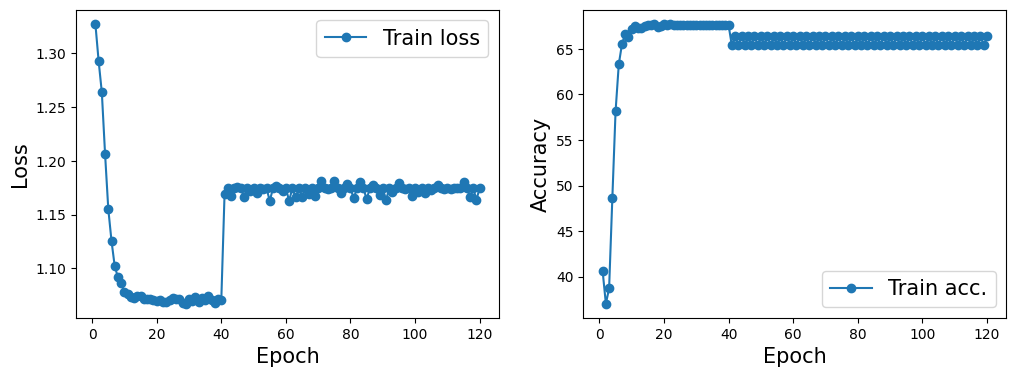

In [47]:
plot_endgame_history(tranv_endgame_hist, tranv_hist)

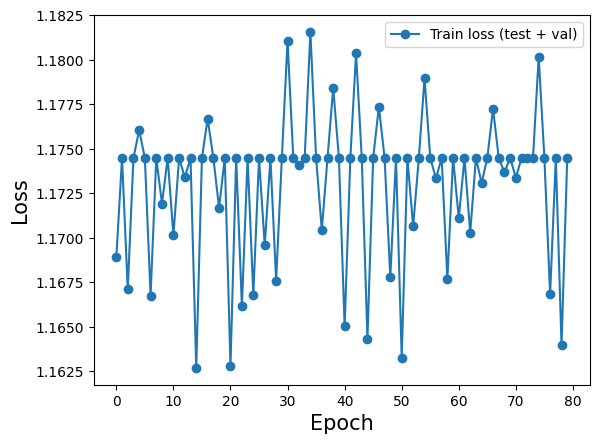

In [61]:
plt.plot(np.arange(len(tranv_endgame_hist[0])), tranv_endgame_hist[0], '-o', label='Train loss (test + val)')
plt.xlabel('Epoch', size=15)
plt.ylabel('Loss', size=15)
plt.legend()
plt.show()

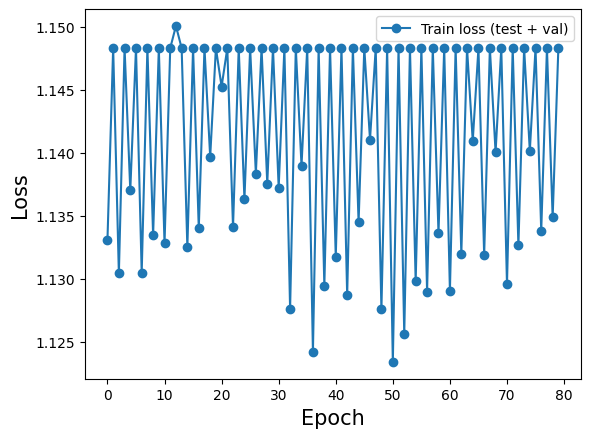

In [62]:
plt.plot(np.arange(len(ang_endgame_hist[0])), ang_endgame_hist[0], '-o', label='Train loss (test + val)')
plt.xlabel('Epoch', size=15)
plt.ylabel('Loss', size=15)
plt.legend()
plt.show()